# Marketing Campaign

## Abstract : 
### This project is motivated from a Blog post by HubSpot, you can see it  __[here](https://blog.hubspot.com/marketing/buyer-persona-research)__ . In it they are guiding us how to create Personas among our clients, and start to understand them better, they also explain why that is so important : "Buyer personas help you understand your customers (and prospective customers) better. This makes it easier for you to tailor your content, messaging, product development, and services to meet the specific needs, behaviors, and concerns of the members of your target audience."

### One of the aspects they are reviewing is also the "Bad" and the "Good" persona. Those are given to our clients in cases we invest a lot of money without a return, and vice versa. This project will have an element, which will shown you how to target the "good" personas, and thus have maximum return, with minimum investement

## Context : 

###  __[Campaign Success Calculator](https://campaign-calculator.herokuapp.com/)__, which measure if our next campaign have a big chance to be successful one and its offer to be accepted among the first runnings. This will be done based on the data we have, and we will process and model it in this project in terms to find the number of persona types, the good or bad ones and if they have different tendency of accepting an offer. 

## Content : 

### The dataset includes information about above 2000 cases for diferent clients and their information (preferences, spendings, etc. ), as well as the outcome, displayed in which campaign they accepted the offer.

## Objective :

### To use Unsupervised and Supervised Machine Learning Algorithms and understand the different patterns, behaviour and personal features, which are driving someone to take an offer. 

## Outcome :

### The result, will be more information for a campaign, we are going even to build a __[Campaign Success Calculator](https://campaign-calculator.herokuapp.com/)__, which could test a hypothetical campaign created from a Digital Marketer automatically. This will help him/her to have a better idea what would be the most probable outcome from his/her campaign even before he started it. This will reduce time and money. Also it would optimize efficiency, as at the end we will have information about what product, to advertise, in which chanels, and on which consumer, aiming to have an sale in the first campaigns.

## The Data set : 

### It is downloaded from __[here](https://www.kaggle.com/rodsaldanha/arketing-campaign/)__ and includes information about : 

Personal :
* ID
* Education - There are options between Basic, 2n Cycle, Graduate, Master and PhD
* Marital Status - There are options between - Single, Married, Divorced, Widow, in Relationship or Alone
* Children - Separatelly for kids and teens in the house
* Income - Information about their income 
* Compain - If the have compained in the past 2 years

Spending : 
* on fish products in the last 2 years (MntFishProducts)
* on meat products in the last 2 years (MntMeatProducts)
* on fruits products in the last 2 years (MntFruits)
* on sweet products in the last 2 years (MntSweetProducts)
* on wine products in the last 2 years (MntWines)
* on gold products in the last 2 years (MntGoldProds)

Shopping habitts: 
* purchases made with discount (NumDealsPurchases)
* purchases made using catalogue (NumCatalogPurchases)
* purchases made directly in stores (NumStorePurchases)
* purchases made through company’s web site (NumWebPurchases)

Loyality : 
* visits to company’s web site in the last month (NumWebVisitsMonth)
* date of customer’s enrolment with the company (DtCustomer)
* number of days since the last purchase (Recency)

# Imports  :

In [1]:
import time

import pandas as pd 
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import scipy.cluster.hierarchy as shc

from sklearn import cluster
from sklearn.preprocessing import MinMaxScaler, Normalizer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.impute import KNNImputer

from sklearn.svm import SVC
from sklearn.neighbors import kneighbors_graph, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import silhouette_samples, silhouette_score, confusion_matrix, classification_report

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from collections import Counter
import pickle

In [2]:
data = pd.read_csv("data/data.csv", sep=";") # Load the data. 

### Second dataset :

We are going to create a new separate dataset for a final validation. In our original one we have some of the outcomes from our campign (but not all of them), which are varying from the clients who take the offer immediately, through those who take it on the 3/4 campign, to those on the last one. 

The idea is to found out, which are the ones, who tend to take the offer in the first campaigns and see their features, after that we can target excatly them (the good persona) in a campaign (which will optimize the result), without giving wrong money for promoting an offer to wrong people (the bad persona), this will reduce money and finally but not least, this will help us to focus on a particular group of people instead putting effort to everyone (this will reduce time). And as you know the time is money ;)

In [3]:
validation = data[["AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "Response"]]

In [4]:
# inspecting the different case scenarios : 
for col in validation:
    print(col, ': ', validation[col][validation[col] == 1].value_counts(), ' labels')

AcceptedCmp1 :  1    144
Name: AcceptedCmp1, dtype: int64  labels
AcceptedCmp2 :  1    30
Name: AcceptedCmp2, dtype: int64  labels
AcceptedCmp3 :  1    163
Name: AcceptedCmp3, dtype: int64  labels
AcceptedCmp4 :  1    167
Name: AcceptedCmp4, dtype: int64  labels
AcceptedCmp5 :  1    163
Name: AcceptedCmp5, dtype: int64  labels
Response :  1    334
Name: Response, dtype: int64  labels


It seems that there is not a big difference in the amount of the people in the separate scenarios, except those who have taken the offer in the last campaign. Overall we have : around 1000 outcomes. This is only the half of our dataset, thus we are not going to use this information as a label or a absolute truth. Instead, we are going to rise a hypothesis (H0) right now from the begining that there would be in someway pattern between the first campaigns in respect to which group, have made more taken offers. The hypothesis will be accepted or rejected at the and. If we have done everything, which follow properly, there would be some logical pattern. 

### H0 - Does the outcome of a campaign, have a pattern for people from a particular group? 

# Cleaning : 

### first we are going to do some steps to make our data set more clear and simple. 
* We are going to extract the years of every person, as for now we have only their year of birth. This will help us to reduce the variety of the numbers in our data set and scale the coulum for their age. There is no point to take 1965 for someone who is only 55 years old. Also, if we leave it like that could confuse us in some point. 
* We are goign to sum up all of their spendings, as if leaving them the way they are there is a threat of very specific samples, which the algorithm to learn and lead to overfiting. 
* We are going to make the marital status simpler, as for now they are mroe than three different categories for a person, who is just single. Our dataset is very small, so it would be better to have more universal results, columns and categories, as if we leave them so specific it will overfit. 
* We are going to combine the columns for the kids and teens in one single, just a child. It would be a binary one: 1 for "Yes" and 0 for "No"

In [5]:
data['age']=2020-data['Year_Birth'] # ages
data['child'] = np.where(data.Kidhome+data.Teenhome > 0, 'Yes', 'No') # child
data['Marital_Status']=data['Marital_Status'].replace({'Divorced':'Alone','Single':'Alone','Married':'In couple','Together':'In couple','Absurd':'Alone','Widow':'Alone','YOLO':'Alone'}) # marital status
data['spending']=data['MntWines']+data['MntFruits']+data['MntMeatProducts']+data['MntFishProducts']+data['MntSweetProducts']+data['MntGoldProds'] # spending

### We have to drop the old columns, add the new ones and rename the leaved ones in a more "Pythonic" way.

In [6]:
data = data.drop(columns = ['Kidhome', "Teenhome", "Year_Birth"])
data = data[["ID", "Income", "spending", 'age','Marital_Status','child','Education', "Recency", "Complain",'MntWines', "MntFruits", "MntMeatProducts", "MntSweetProducts", "MntGoldProds", "MntFishProducts", "NumDealsPurchases", "NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases", "NumWebVisitsMonth", "AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "Response"]]
data.columns = ["id", "income", "spending", 'age','marital','child','education', "recency", "complain", 'wines', "fruits", "meat", "sweets", "gold", "fish", "deals", "web_p", "catalog_p", "store_p", "web_visit", "AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "Response"]

### Now we are going to make dummies variables four our categorical columns. 

In [7]:
ids = data.id
new = pd.get_dummies(data[["marital", "education", "child"]]) # transforming our categorical variables.
data = data.join([new]) # joining the result to the dataframe

### Here we have to be very carefull, in case to surpass the Dummy Trap : 
What is it ? 
When defining dummy variables, a common mistake is to define too many variables. If a categorical variable can take on k values, it is tempting to define k dummy variables. Resist this urge. Remember, you only need k - 1 dummy variables.

A kth dummy variable is redundant; it carries no new information. And it creates a severe multicollinearity problem for the analysis. Using k dummy variables when only k - 1 dummy variables are required is known as the dummy variable trap. Avoid this trap! 
 __[source](https://stattrek.com/multiple-regression/dummy-variables.aspx)__

In [8]:
data = data.drop(columns = ["marital", "child","marital_In couple", "child_No", "education_Basic"])

We were not drop the education column, as we are going to use it later in the EDA, please not it will be drop before the normalization for modeling . 

In [9]:
data.describe() # We can inspect further. 

id         income     spending          age      recency  \
count   2240.000000    2216.000000  2240.000000  2240.000000  2240.000000   
mean    5592.159821   52247.251354   605.798214    51.194196    49.109375   
std     3246.662198   25173.076661   602.249288    11.984069    28.962453   
min        0.000000    1730.000000     5.000000    24.000000     0.000000   
25%     2828.250000   35303.000000    68.750000    43.000000    24.000000   
50%     5458.500000   51381.500000   396.000000    50.000000    49.000000   
75%     8427.750000   68522.000000  1045.500000    61.000000    74.000000   
max    11191.000000  666666.000000  2525.000000   127.000000    99.000000   

          complain        wines       fruits         meat       sweets  ...  \
count  2240.000000  2240.000000  2240.000000  2240.000000  2240.000000  ...   
mean      0.009375   303.935714    26.302232   166.950000    27.062946  ...   
std       0.096391   336.597393    39.773434   225.715373    41.280498  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000000    23.750000     1.000000    16.000000     1.000000  ...   
50%       0.000000   173.500000     8.000000    67.000000     8.000000  ...   
75%       0.000000   504.250000    33.000000   232.000000    33.000000  ...   
max       1.000000  1493.000000   199.000000  1725.000000   263.000000  ...   

       AcceptedCmp3  AcceptedCmp4  AcceptedCmp5     Response  marital_Alone  \
count   2240.000000   2240.000000   2240.000000  2240.000000    2240.000000   
mean       0.072768      0.074554      0.072768     0.149107       0.355357   
std        0.259813      0.262728      0.259813     0.356274       0.478728   
min        0.000000      0.000000      0.000000     0.000000       0.000000   
25%        0.000000      0.000000      0.000000     0.000000       0.000000   
50%        0.000000      0.000000      0.000000     0.000000       0.000000   
75%        0.000000      0.000000      0.000000     0.000000       1.000000   
max        1.000000      1.000000      1.000000     1.000000       1.000000   

       education_2n Cycle  education_Graduation  education_Master  \
count         2240.000000           2240.000000       2240.000000   
mean             0.090625              0.503125          0.165179   
std              0.287139              0.500102          0.371425   
min              0.000000              0.000000          0.000000   
25%              0.000000              0.000000          0.000000   
50%              0.000000              1.000000          0.000000   
75%              0.000000              1.000000          0.000000   
max              1.000000              1.000000          1.000000   

       education_PhD    child_Yes  
count    2240.000000  2240.000000  
mean        0.216964     0.715179  
std         0.412270     0.451430  
min         0.000000     0.000000  
25%         0.000000     0.000000  
50%         0.000000     1.000000  
75%         0.000000     1.000000  
max         1.000000     1.000000  

[8 rows x 29 columns]

### Outcomes : 
* Average income is 52247 dollars 
* The income distribution is right skewed with the possible presence of outliers
* The maximum value being equal to 666666 dollars
* The 3rd quartile being only equal to 68522 dollars reinforce the outlier's hypothesis
* Average spending in the last 2 years is 600 dollars 
* median spending is 396 dollars
* Average age is 45 years old
* The oldest customer is 121 years old

## But, most important we have missing values in income column . 
We can drop it, replace it with mean or other more creative approaches. As our data set is not so big I assume the information for missing incomes would be very important. This is also our most varying column and we have a hypothesis about outliers in it. Thus, the missing values could be in any range. For that reason, I decide to replace them with a model to predict the missing values 

In [10]:
mputer = KNNImputer()
imputer = KNNImputer(n_neighbors=5,metric='nan_euclidean')
imputer.fit(data[['income','age', "spending"]])
X = imputer.transform(data[['income','age',"spending"]])
Income_impute=pd.DataFrame(X,columns=['income','age', "spending"])
data["income"]=Income_impute["income"]
count_nan = len(data) - data.count()
print(count_nan)

id                      0
income                  0
spending                0
age                     0
education               0
recency                 0
complain                0
wines                   0
fruits                  0
meat                    0
sweets                  0
gold                    0
fish                    0
deals                   0
web_p                   0
catalog_p               0
store_p                 0
web_visit               0
AcceptedCmp1            0
AcceptedCmp2            0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
Response                0
marital_Alone           0
education_2n Cycle      0
education_Graduation    0
education_Master        0
education_PhD           0
child_Yes               0
dtype: int64


# EDA (Explanatory Data Analysis) :
### 1. We are going to find and visualize the outliers
   a/ We are going to visualize the distribution of the most varying coulumns: 

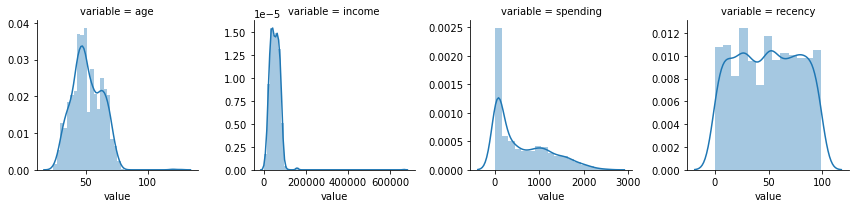

In [11]:
df = pd.DataFrame(data=data, columns=['age','income','spending', "recency"])
nd = pd.melt(df, value_vars =df )

n1 = sns.FacetGrid (nd, col='variable', col_wrap=5, sharex=False, sharey = False)
n1 = n1.map(sns.distplot, 'value')

plt.savefig('graphs/variety_of_values.png')
plt.show()

b/ Next, we are going to see if there are outliers in more interactive way : 

In [12]:
fig = px.box(df.melt(), y="value", facet_col="variable",facet_col_wrap=2, boxmode="overlay", color="variable",height=1000, width=900)
fig.update_yaxes(matches=None)

for i in range(len(fig["data"])):
    yaxis_name = 'yaxis' if i == 0 else f'yaxis{i + 1}'
    fig.layout[yaxis_name].showticklabels = True

fig.update_layout(showlegend=False)
fig.update_xaxes(showline=True, linewidth=2, linecolor='grey')
fig.update_yaxes(showline=True, linewidth=2, linecolor='grey')

fig.show()

## From above we can see that several variables seem to have outliers :
* Age: 3 customers older than the Upper Fence set at 80 years old. We will not remove them
* Income : Several value are greater than the Upper Fence of 113K. While having an income of 150k is not impossible, we will remove the customer who has an income of 666k. 
* Spending : There is only one outlier which is at the limit of the Upper Fence. We will not remove it

### We also can visualize the whole data (in two dimensional space) agumerative, thus it will be easy to spot the outliers.

As this time, we want more a broad visualization than a numeric inspection, we are going to scale the values, so it will be more clearer to spot an extremely different values. Please note we are not including the ids and the outcomes, as they will counfuse everything, and actually do not have a real connection with what we are trying to do now. 

In [13]:
features = data[["income", 'spending', 'age', 'recency', 'complain', 'wines','fruits', 'meat', 'sweets', 'gold','fish', 'deals', 'web_p','catalog_p', 'store_p', 'web_visit','marital_Alone', 'education_2n Cycle','education_Graduation', 'education_Master', 'education_PhD','child_Yes']]

In [14]:
normalizer = Normalizer()
normalizer_data = normalizer.fit_transform(features)

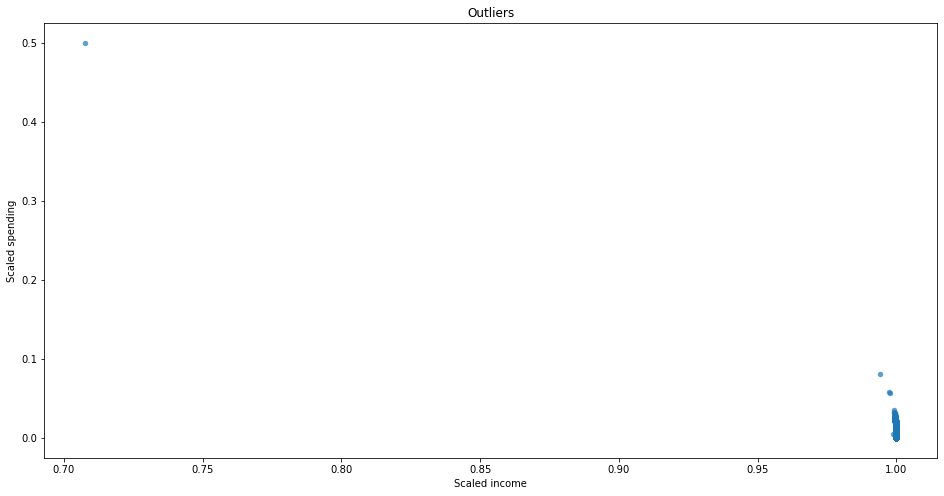

In [15]:
fig, ax = plt.subplots(figsize=(16,8))

ax.scatter(normalizer_data[:, 0], normalizer_data[:, 1], marker='o', s=30, lw=0, alpha=0.7)

ax.set_title('Outliers')
ax.set_xlabel('Scaled income')
ax.set_ylabel('Scaled spending')

plt.savefig('graphs/outliers.png')
plt.show()

It is clear how the outlier is not only the one from the income column. There are more of them.

### Removing the outliers : 

In [16]:
data = data[data['income']<600000] # the one in the income variable

For the rest of them we are going to use a slightly different approach

In [17]:
max_thresold = data['income'].quantile(0.95)
min_thresold = data['income'].quantile(0.05)
data = data[(data['income']<max_thresold) & (data['income']>min_thresold)]

Now we can get rid from the validation columns and the id 

In [18]:
validation = data[["AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "Response"]] # selecting them.
data = data.drop(validation, axis=1)
validation.columns = ["first", "second", "third", "fourth", "fifth", "last"]

In [19]:
ids = data.id
data = data.drop(columns = ["id"])

Lets see if the visualization have gone under a change : 

In [20]:
data.to_csv("data/cleaned.csv", index = False)

In [21]:
features = data[["income", 'spending', 'age', 'recency', 'complain', 'wines','fruits', 'meat', 'sweets', 'gold','fish', 'deals', 'web_p','catalog_p', 'store_p', 'web_visit','marital_Alone', 'education_2n Cycle','education_Graduation', 'education_Master', 'education_PhD','child_Yes']]

In [22]:
normalizer = Normalizer()
normalizer_data = normalizer.fit_transform(features)

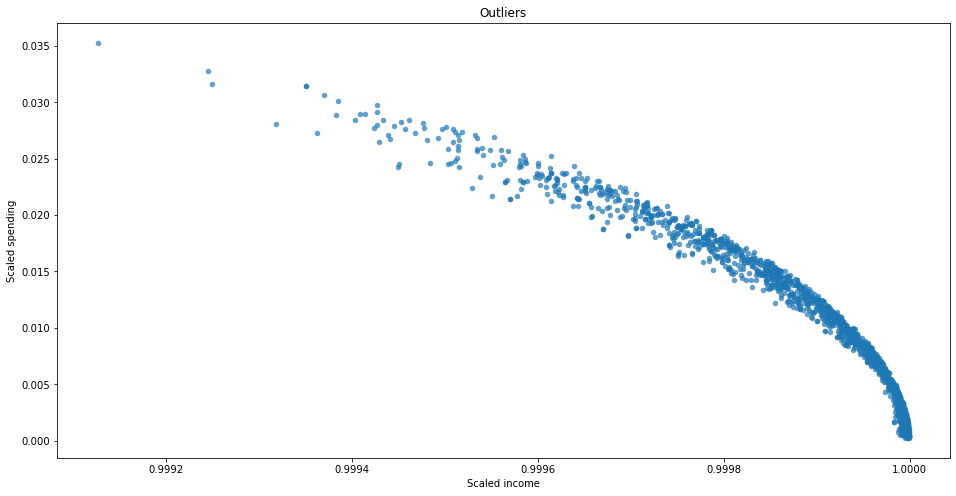

In [23]:
# First we need to scale the newly created dataframe again :

fig, ax = plt.subplots(figsize=(16,8))

ax.scatter(normalizer_data[:, 0], normalizer_data[:, 1], marker='o', s=30, lw=0, alpha=0.7)

ax.set_title('Outliers')
ax.set_xlabel('Scaled income')
ax.set_ylabel('Scaled spending')

plt.savefig('graphs/without_outliers.png')
plt.show()

Now the markers are closer to each other, so we will assume we have fix the problem with the outliers.

In [24]:
plt.style.use('fivethirtyeight')

## Now is a time to ask and answer more questions about our clients, products and channels : 

### lets see which products bring us most revenue : 

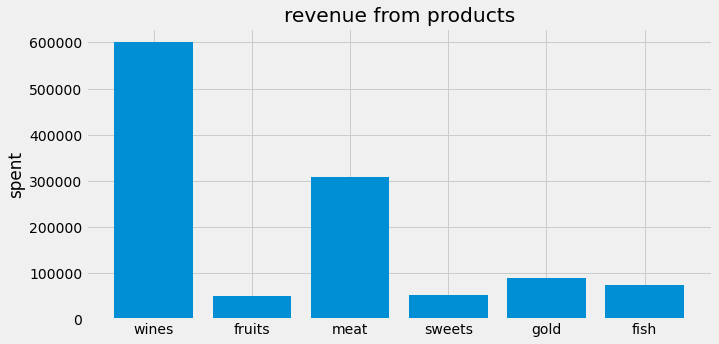

In [25]:
wines = data.wines.sum()
fruits = data.fruits.sum()
meat = data.meat.sum()
sweets = data.sweets.sum()
gold = data.gold.sum()
fish = data.fish.sum()

plt.figure(figsize=(10,5))
plt.bar(range(6), [wines, fruits, meat, sweets, gold, fish])
plt.title('revenue from products')
plt.xticks(range(6), ["wines", "fruits", "meat", "sweets", "gold", "fish"])
plt.ylabel("spent")
plt.savefig('graphs/revenue_from_products.png')
plt.show()

### H1- If our clinets buy wine most, can we assume they are young (and Wild xD)  : 

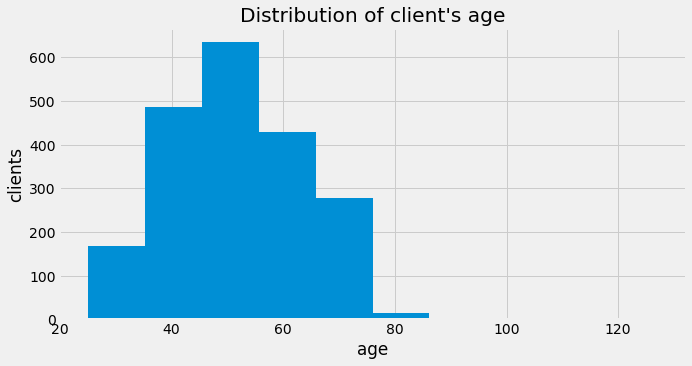

In [26]:
plt.figure(figsize=(10,5))
plt.hist(data.age)
plt.title("Distribution of client's age")
plt.xlabel("age")
plt.ylabel("clients")
plt.savefig('graphs/clients_age.png')
plt.show()

### H1 rejected - It seems the people beteween 40 and 60 are the party animals .

### Is there are pattern in range of a purchasing between the last order : 

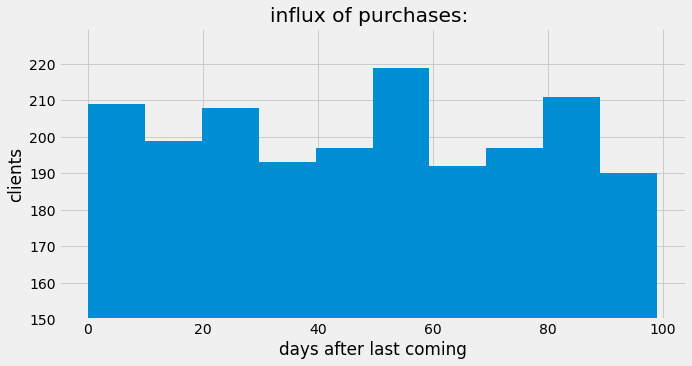

In [27]:
plt.figure(figsize=(10,5))
plt.hist(data.recency)
plt.title("influx of purchases: ")
plt.xlabel("days after last coming")
plt.ylabel("clients")
plt.ylim(ymin=150)
plt.savefig('graphs/recency.png')
plt.show()

### Which channel for purchasing bring us most revenue : 

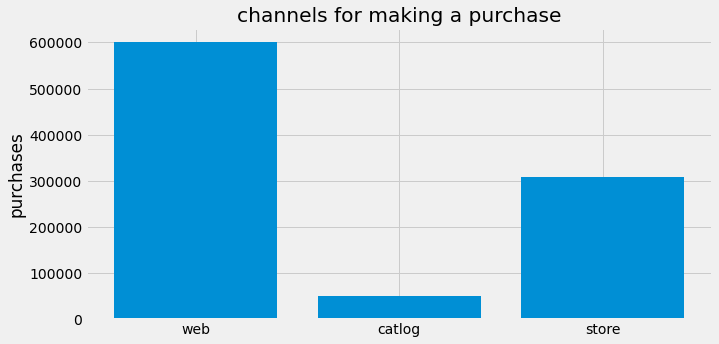

In [28]:
web_p = data.wines.sum()
catalog_p = data.fruits.sum()
store_p = data.meat.sum()

plt.figure(figsize=(10,5))
plt.bar(range(3), [web_p, catalog_p, store_p])
plt.title('channels for making a purchase')
plt.xticks(range(3), ["web", "catlog", "store"])
plt.ylabel("purchases")
plt.savefig('graphs/channels.png')
plt.show()

### H2 - Does the most clients visit our site only once ? 

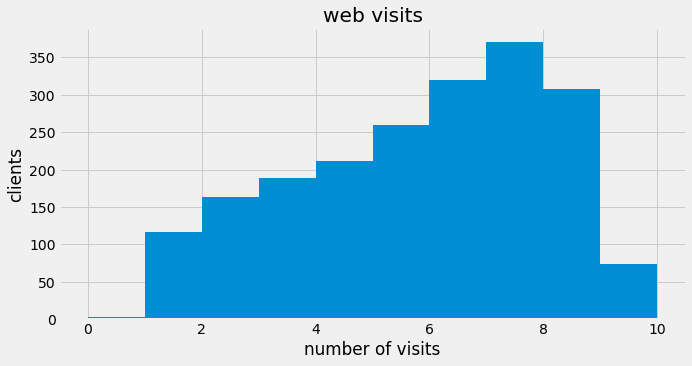

In [29]:
plt.figure(figsize=(10,5))
plt.hist(data.web_visit)
plt.title("web visits")
plt.xlabel("number of visits")
plt.ylabel("clients")
plt.savefig('graphs/web_visits.png')
plt.show()

### H2 - rejected - It seems a lot of them have checked our web site a lot, between 6-8 times. Later we are going to see if this bring a real significance to our revenue. 

### Lets see what are the educations for people with or without a child : 

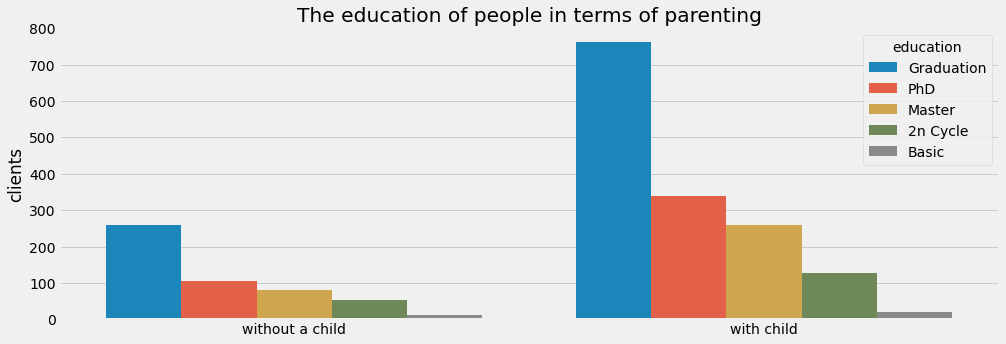

In [30]:
plt.figure(figsize = (15,5))
sns.countplot(x=data['child_Yes'],order=[0, 1],hue=data['education'])
plt.title("The education of people in terms of parenting")
plt.ylabel("clients")
plt.xlabel("")
plt.xticks(range(2), ["without a child", "with child"])
plt.savefig('graphs/education.png')
plt.show()

### It seems a lot of people with child are only Graduates. Now we are going to do the same, but this time for their relationship status : 

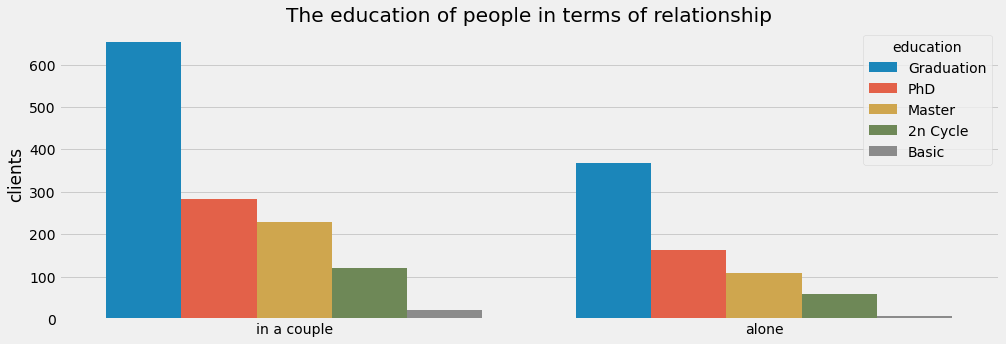

In [31]:
plt.figure(figsize = (15,5))
sns.countplot(x=data['marital_Alone'],order=[0, 1],hue=data['education'])
plt.title("The education of people in terms of relationship")
plt.ylabel("clients")
plt.xlabel("")
plt.xticks(range(2), ["in a couple", "alone"])
plt.savefig('graphs/eduaction1.png')
plt.show()

There is not a big difference this time. 

### H3 - Do the people with higher income buy more ? 

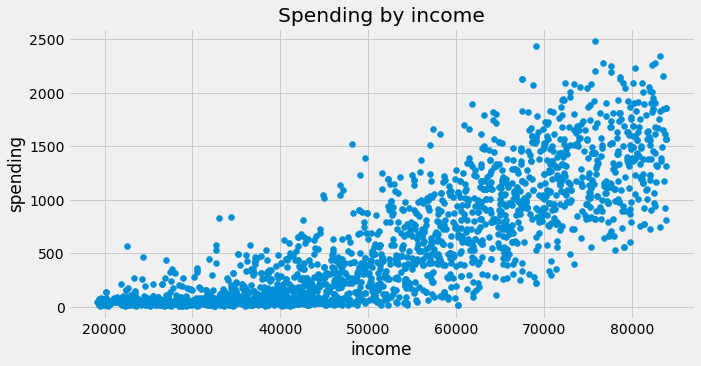

In [32]:
plt.figure(figsize=(10,5))
plt.scatter(data.income, data.spending)
plt.xlabel("income")
plt.ylabel("spending")
plt.title("Spending by income")
plt.savefig('graphs/spending_by_income.png')
plt.show()

### H3 - approved - it was logical one, but worth checking. 

# Clustering

### In this section we are going to try different Unsupervised Clustering Algorithms and their techniques for deciding the optimal number of clusters. During the proces, labels of groups/clusters will be created and we will use them in the next section dedicated to the Supervised Algorithm. 

## 1. Hierarchical clustering

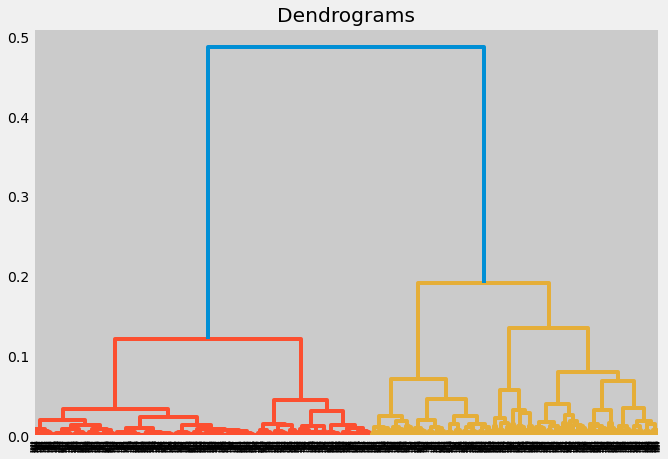

In [33]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms") 
dend = shc.dendrogram(shc.linkage(normalizer_data, method='ward'))
plt.savefig('graphs/hierarchical_clustering.png')

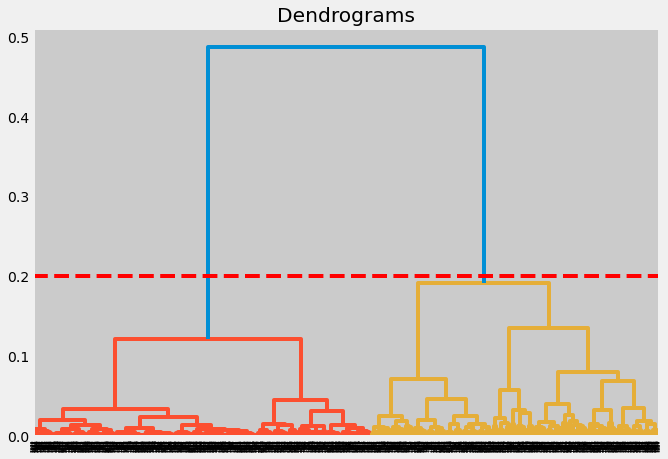

In [34]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(normalizer_data, method='ward'))
plt.axhline(y=0.2, color='r', linestyle='--')
plt.savefig('graphs/hierarchical_line.png')

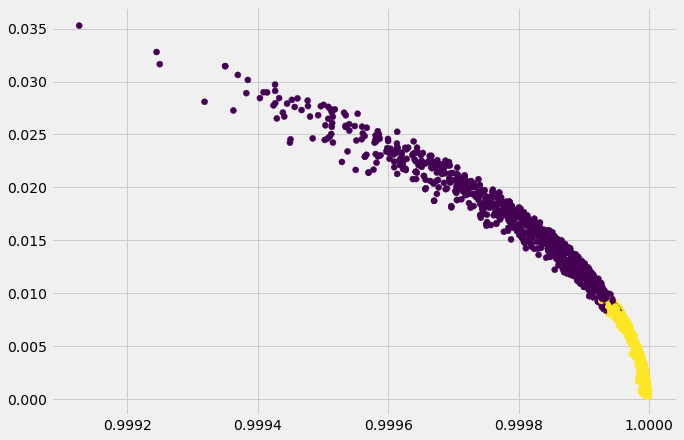

In [35]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward').fit(normalizer_data)
plt.figure(figsize=(10, 7))  
plt.scatter(normalizer_data[:, 0], normalizer_data[:, 1], c=cluster.labels_)
plt.savefig('graphs/hierarchical_clusters.png')
plt.show()

### The first method showed us two clusters will be perfect. 
Now we can continue with K Means, where the number of clusters will be decided not from us but instead from the Elbow Method. Let's pay particular attention if there will be a significant difference in the result. 

In [36]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(normalizer_data)
    Sum_of_squared_distances.append(km.inertia_)

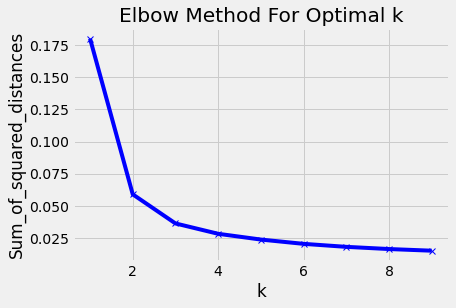

In [37]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.savefig('graphs/elbow_method.png')
plt.show()

### Here 2/3 seems a good choices, however to be sure we are going to use they distribution and silhouette score.

For n_clusters = 2 The average silhouette_score is : 0.5765170498157303
For n_clusters = 3 The average silhouette_score is : 0.5082059993953006
For n_clusters = 4 The average silhouette_score is : 0.45410225343737964
For n_clusters = 5 The average silhouette_score is : 0.4540048333968389
For n_clusters = 6 The average silhouette_score is : 0.4262007267262853


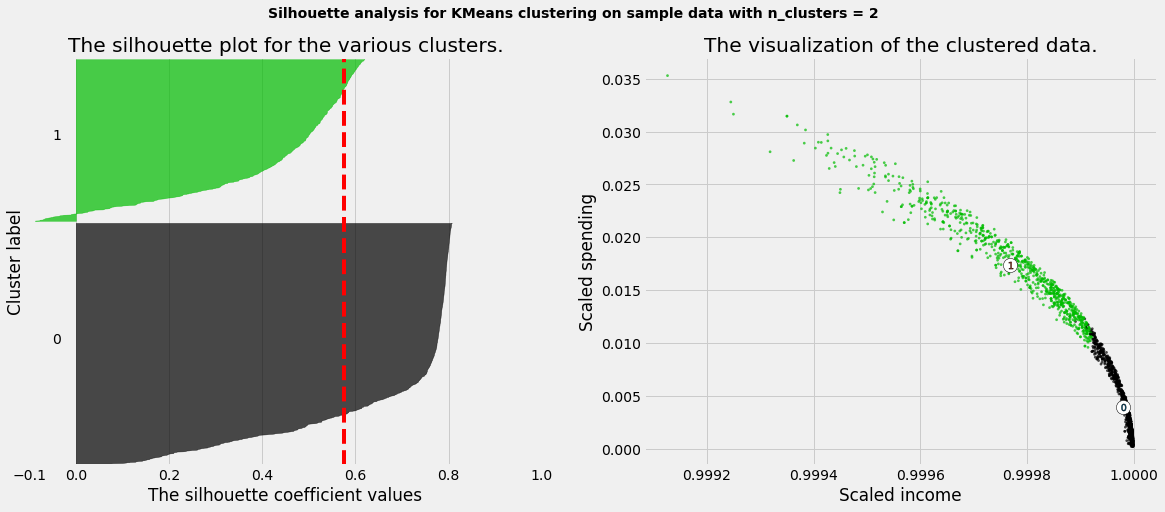

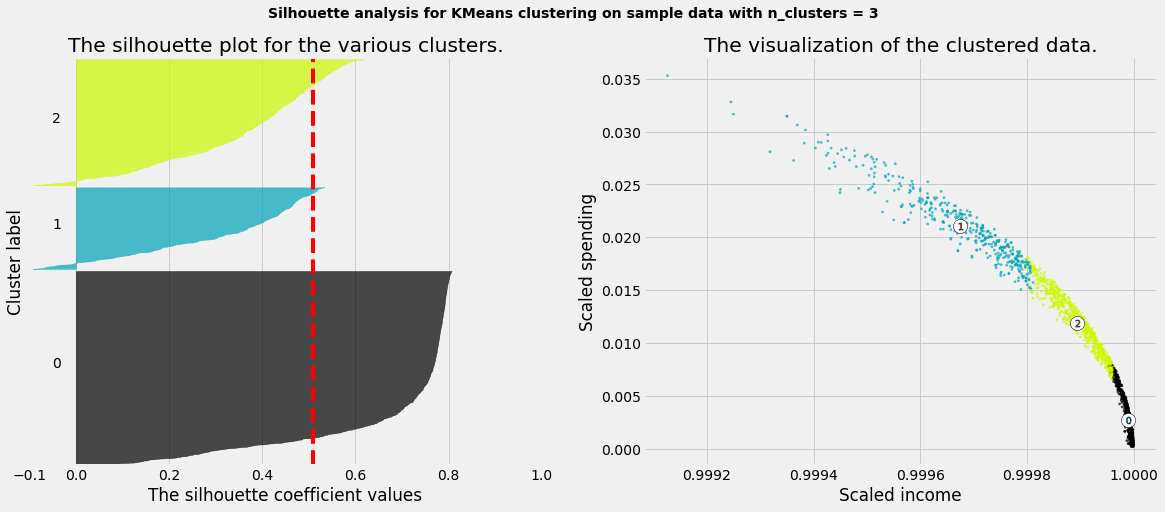

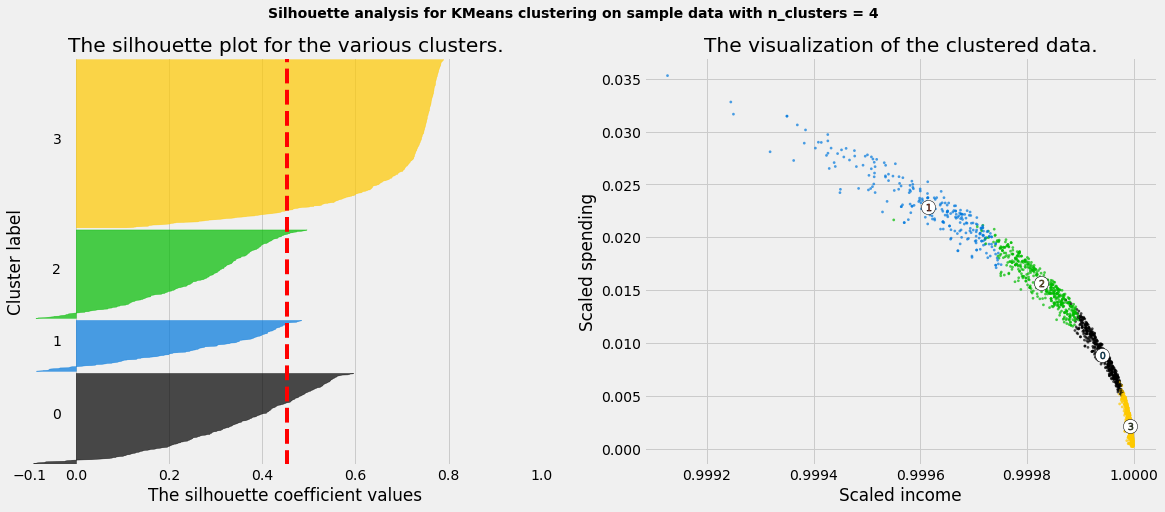

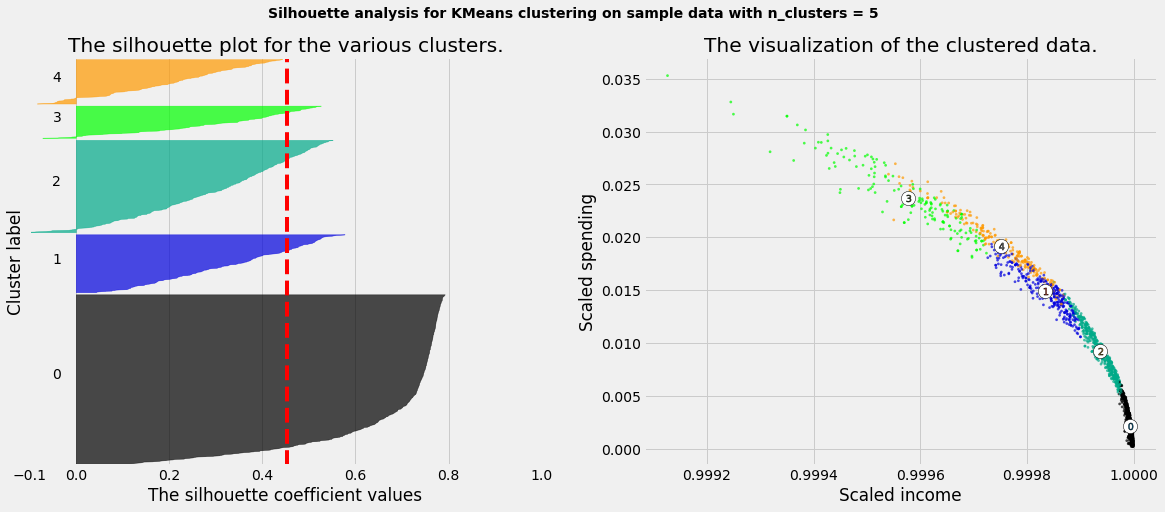

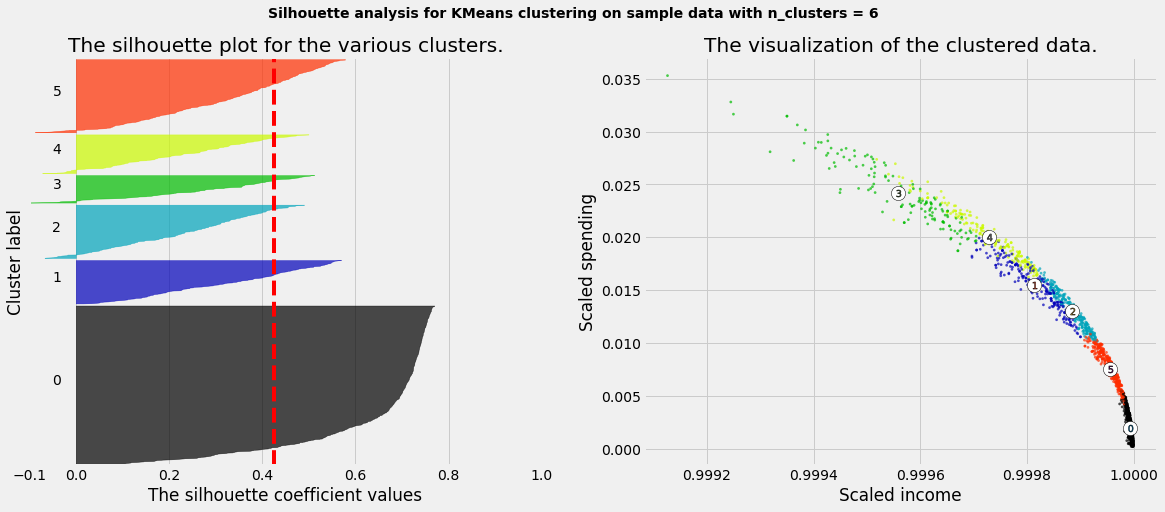

In [38]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(normalizer_data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(normalizer_data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(normalizer_data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(normalizer_data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(normalizer_data[:, 0], normalizer_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Scaled income")
    ax2.set_ylabel("Scaled spending")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    
    plt.savefig('graphs/silhouette_analysis{}.png'.format(n_clusters))
plt.show()

### We could conclude, with that the number of 2 clusters is not only the best choice because the two algorithms and their technique adviced us to do so, but also because the silhouette score is biggest in that case and it is the the most proportionally distubited case from the graphs.

In [39]:
kmeans = KMeans(n_clusters=2,max_iter=50, random_state=42).fit(normalizer_data)
data["labels"] = kmeans.labels_

### Now we can generalize more graphs in terms to understand our clients and their clusters more :

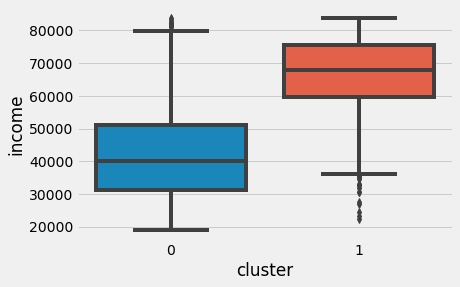

In [40]:
sns.boxplot(x='labels', y='income', data=data)
plt.savefig('graphs/clusters_income.png')
plt.ylabel("income")
plt.xlabel("cluster")
plt.show()

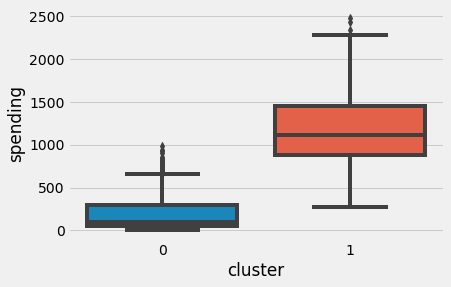

In [41]:
sns.boxplot(x='labels', y='spending', data=data)
plt.savefig('graphs/clusters_spending.png')
plt.ylabel("spending")
plt.xlabel("cluster")
plt.show()

### Logically, those who earn more money tends to spend more, it is a good sign that shows our model have made logical connections. Lets continue.. Maybe later we could see that excatly those people are the ones, who bring us most revenue. 

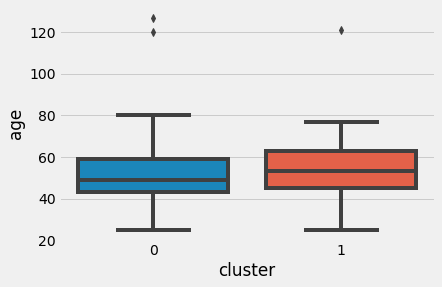

In [42]:
sns.boxplot(x='labels', y='age', data=data)
plt.savefig('graphs/clusters_age.png')
plt.ylabel("age")
plt.xlabel("cluster")
plt.show()

### Its seems there is not a significant difference in the ages of our clients based on their groups.

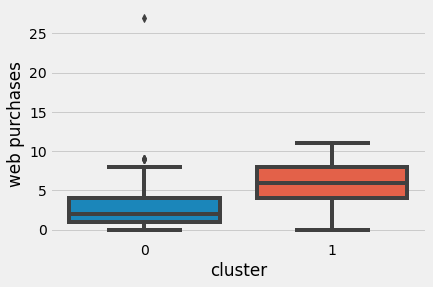

In [43]:
sns.boxplot(x='labels', y='web_p', data=data)
plt.savefig('graphs/web_p.png')
plt.ylabel("web purchases")
plt.xlabel("cluster")
plt.show()

### Here we can make an hypothesis (H4) if the persona which tends to visit our website more, actually buys from it more. 

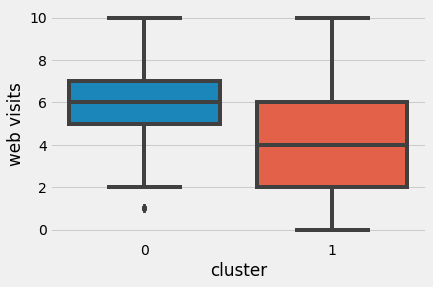

In [44]:
sns.boxplot(x='labels', y='web_visit', data=data)
plt.savefig('graphs/web_visits.png')
plt.ylabel("web visits")
plt.xlabel("cluster")
plt.show()

### There is a good thing to point out. We just found out, who are our good and bad personas. As you see the people who tends to come on our site are not the ones who buys from it . Thus, the 0 label is a bad persona, and the 1 is a good one.  Here we can go to two conclusions : 
* If we promote something on our site maybe it wont be so efficient. 
* If we target our "good" persona, even on another platform, through another channel , there is a big chance he or she, to come on our site, excatly to make a purchase.

### H4 is rejceted. 

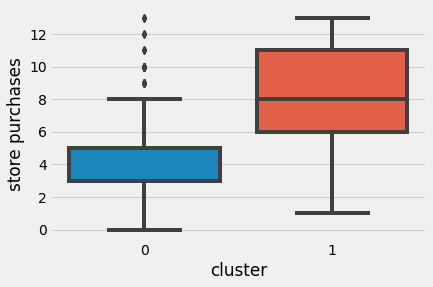

In [45]:
sns.boxplot(x='labels', y='store_p', data=data)
plt.savefig('graphs/store_p.png')
plt.ylabel("store purchases")
plt.xlabel("cluster")
plt.show()

### Also our "good" persona seems to bring us more revenue, by default through the traditional way. 

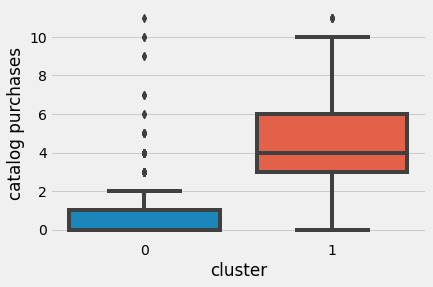

In [46]:
sns.boxplot(x='labels', y='catalog_p', data=data)
plt.savefig('graphs/catalog_p.png')
plt.ylabel("catalog purchases")
plt.xlabel("cluster")
plt.show()

### They seems to dominate the modern way, as well. 

# Demographic information : 

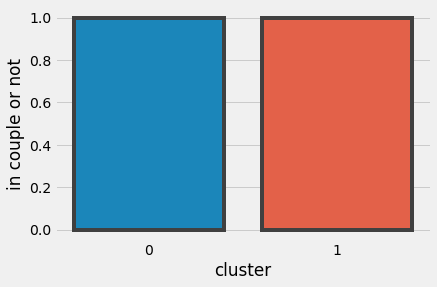

In [47]:
sns.boxplot(x='labels', y='marital_Alone', data=data)
plt.savefig('graphs/marital.png')
plt.ylabel("in couple or not")
plt.xlabel("cluster")
plt.show()

### Both personas , have representatives from both marital status, so this could not make a lot of sense to us, lets see if it is the same with the child : 

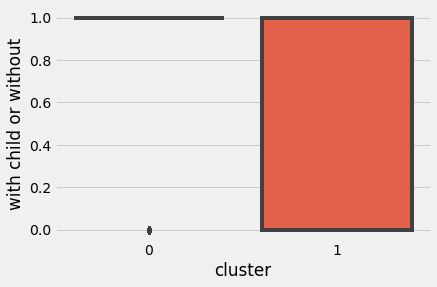

In [48]:
sns.boxplot(x='labels', y='child_Yes', data=data)
plt.savefig('graphs/child.png')
plt.ylabel("with child or without")
plt.xlabel("cluster")
plt.show()

### Now we have more crucial information. The wining persona have both cases (with child or without in the house). However, if we look at the other persona, we could see it is dominated with the people who have child. Thus ,if we want to make our campaign even more detailed, we could be limit the cases where someone have a child in the house.

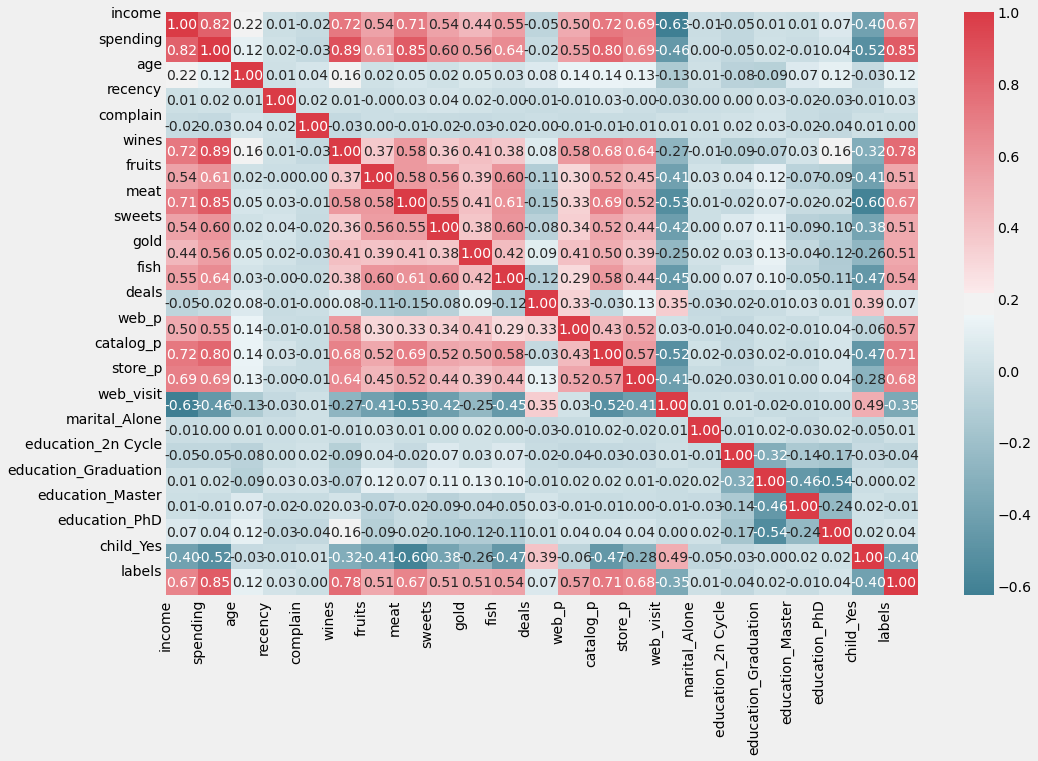

In [49]:
corr = data.corr()
fig, ax = plt.subplots(figsize=(15,10))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns)
plt.savefig('graphs/correlation.png')
plt.show()

# To coclude with the EDA, we could say : 

### Most evident is that those, who do not have childrens, tends to earn a lot, spend a lot and make purchases in any kind. The only thing that they are not so active is to visit our website. The same time they also are on the top, when it comes to buy something from the website. That means only one thing. Whenever they decide to come and visit our website they have come to make a purchase, not only to look around. They are our "good" persona. 

# Supervised
### Now as we have the labels, and they seems to make a logical predictions, we could use them to build a model for a future clients, and how to target them on the chanels and with what offers, to take their attention. 
### As now we are going to make a model to evaluate for which persona someone would fall, and thus if his persona is willing to take an offer in the first campaigns, we are going to modify our data a little bit : 
* We do not have information about the income of one future consumer. 
* We do not know how much he have spent on our shop, as we are targeting new potential clients. 
* We do not also know how much they have spent on a particular product. 
* As we see there is no particular difference between the ages of the clients, we will drop that, as well. 
* We will drop the deals column, it is logical if we are striving to target new user, he or she not to have done deals with us, yet.
* Also, we cannot know how many visits we have on our web site.
Thus we are going to use less data for our model. 
### We are going to use something more creative : 
* We will scale the data, to 1 and 0. 
This means instead of the exact number of purchased products, we could take it as an index of how much this persona prefer this type of products. Thus, we can use it in our calculator to find, which product is good to use for our campaign as there is already proven connection between their preference. 
* We are going first to do a feature engineering in case to found the most relevant features, and tunne our model for the most broad real world example, this will contribute for the preventing of overfiting. 


In [50]:
data = data[['wines','fruits', 'meat', 'sweets', 'gold','fish', 'web_p','catalog_p', 'store_p','marital_Alone', 'education_2n Cycle', 'education_Graduation','education_Master', 'education_PhD', 'child_Yes', 'labels']]
labels = data.labels
data = data.drop(columns = ['labels'])

In [51]:
# training set
data_train, data_test, labels_train, labels_test = train_test_split(
data, labels, train_size = 0.6, stratify = labels, random_state=42)

In [52]:
# validation and testing set
data_validation, data_test, labels_validation, labels_test = train_test_split(
data_test, labels_test, train_size = 0.50, stratify = labels_test, random_state=42)

In [53]:
scaler = MinMaxScaler()

In [54]:
data_train = scaler.fit_transform(data_train)
data_validation = scaler.transform(data_validation)
data_test = scaler.transform(data_test)

## Feature Engenering.

For the feature importance I am going to use the Random Forest model, and tune it first.

In [55]:
model = RandomForestClassifier(n_jobs=-1, random_state=42)
param_dict = { 'n_estimators':[5,10,15],
               'max_depth':[10,20,30],
               'criterion': ['gini','entropy']
              }

In [56]:
best_forest = GridSearchCV(model, param_dict, cv=5) 
best_forest.fit(data_train, labels_train)
print("best parameters : ", best_forest.best_params_)
print("best score :", best_forest.best_score_)

best parameters :  {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 15}
best score : 0.9478961626830357


In [57]:
model = RandomForestClassifier(criterion = "gini", max_depth = 10 ,n_estimators=15, n_jobs=-1, random_state=42)
model.fit(data_train, labels_train)

features = data.columns
importances = model.feature_importances_
indices = np.argsort(importances)

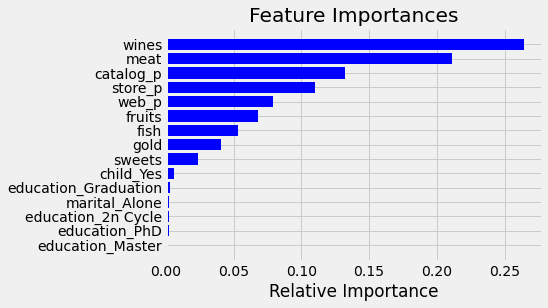

In [58]:
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.savefig('graphs/feature_importance.png')
plt.show()

## We can see there is not a lot of importance of someone's degree and marital status, so we are going to drop those features in terms to improve the model . 

In [59]:
data = data[['wines','fruits', 'meat', 'sweets', 'gold','fish', 'web_p','catalog_p', 'store_p','child_Yes']]

## Now as we have the right features, it is time to evaluate Supervised algorithms and choose one final one to our model. 

In [60]:
# Spliting with the new data
data_train, data_test, labels_train, labels_test = train_test_split(
data, labels, train_size = 0.6, stratify = labels, random_state=42)

In [61]:
# Spliting with the new data
data_validation, data_test, labels_validation, labels_test = train_test_split(
data_test, labels_test, train_size = 0.50, stratify = labels_test, random_state=42)

In [62]:
# Scaling the new data 
data_train = scaler.fit_transform(data_train)
data_validation = scaler.transform(data_validation)
data_test = scaler.transform(data_test)

In [63]:
dict_classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=18),
}

no_classifiers = len(dict_classifiers.keys())

In [64]:
def batch_classify(X_train, Y_train, verbose = True):
    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,3)), columns = ['classifier', 'train_score', 'training_time'])
    count = 0
    for key, classifier in dict_classifiers.items():
        t_start = time.clock()
        classifier.fit(X_train, Y_train)
        t_end = time.clock()
        t_diff = t_end - t_start
        train_score = classifier.score(X_train, Y_train)
        df_results.loc[count,'classifier'] = key
        df_results.loc[count,'train_score'] = train_score
        df_results.loc[count,'training_time'] = t_diff
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=key, f=t_diff))
        count+=1
    return df_results

In [65]:
df_results = batch_classify(data_train, labels_train)

/home/indzhov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead

/home/indzhov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead

/home/indzhov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead

/home/indzhov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



trained Logistic Regression in 0.30 s
trained Nearest Neighbors in 0.04 s
trained Linear SVM in 0.05 s
trained Decision Tree in 0.01 s


/home/indzhov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead

/home/indzhov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead

/home/indzhov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead

/home/indzhov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead

/home/indzhov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.p

trained Random Forest in 0.09 s


In [66]:
df_results.sort_values(by='train_score', ascending=False)

classifier  train_score  training_time
3        Decision Tree     1.000000       0.007275
4        Random Forest     0.999173       0.091524
1    Nearest Neighbors     0.956162       0.041999
2           Linear SVM     0.952854       0.047851
0  Logistic Regression     0.948718       0.303117

### Some of those reults, seems to overfit so we are going to use cross validation for more appropriate choosing. 

In [67]:
# Logistic Regression
log_reg = LogisticRegression()
log_scores = cross_val_score(log_reg, data_train, labels_train, cv=3)
log_reg_mean = log_scores.mean()

# SVC
svc_clf = SVC()
svc_scores = cross_val_score(svc_clf, data_train, labels_train, cv=3)
svc_mean = svc_scores.mean()

# KNearestNeighbors
knn_clf = KNeighborsClassifier()
knn_scores = cross_val_score(knn_clf, data_train, labels_train, cv=3)
knn_mean = knn_scores.mean()

# Decision Tree
tree_clf = DecisionTreeClassifier()
tree_scores = cross_val_score(tree_clf, data_train, labels_train, cv=3)
tree_mean = tree_scores.mean()

# Random Forest Classifier
rand_clf = RandomForestClassifier(n_estimators=18)
rand_scores = cross_val_score(rand_clf, data_train, labels_train, cv=3)
rand_mean = rand_scores.mean()

# Create a Dataframe with the results.
d = {'Classifiers': ['Logistic Reg.', 'SVC', 'KNN', 'Dec Tree', 'Rand FC'], 
    'Crossval Mean Scores': [log_reg_mean, svc_mean, knn_mean, tree_mean, rand_mean]}
result_df = pd.DataFrame(data=d)
result_df.sort_values(by='Crossval Mean Scores', ascending=False)

Classifiers  Crossval Mean Scores
1            SVC              0.946237
0  Logistic Reg.              0.943755
2            KNN              0.942101
4        Rand FC              0.937965
3       Dec Tree              0.913978

### It seems we are going to use Random Forest again. 

In [68]:
model.fit(data_train, labels_train)

RandomForestClassifier(max_depth=10, n_estimators=15, n_jobs=-1,
                       random_state=42)

In [69]:
def get_scores(estimator):
    print("Train: ", estimator.score(data_train, labels_train))
    print("Validation: ", estimator.score(data_validation, labels_validation))  

In [70]:
get_scores(model)

Train:  0.9950372208436724
Validation:  0.9602977667493796


The score is better from the last time, thus our Feature Engenering was successful.

### Now, lets see how better our algorithm predict a new data : 
* We are going to create a confusion matrix
* Then we are going to try : 
* Oversampling
* Undersampling
* Both 
   
    with aim to see if we could improve the prediction even more. 

In [71]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [72]:
labels_pred = model.predict(data_test)

Confusion matrix, without normalization
[[234   7]
 [  8 154]]


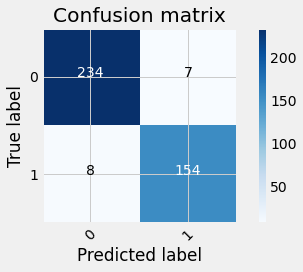

In [73]:
cm = confusion_matrix(labels_test, labels_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1])
plt.show()

In [74]:
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       241
           1       0.96      0.95      0.95       162

    accuracy                           0.96       403
   macro avg       0.96      0.96      0.96       403
weighted avg       0.96      0.96      0.96       403



# Oversampling :

In [75]:
print(Counter(labels_train))

Counter({0: 723, 1: 486})


In [76]:
over = RandomOverSampler(sampling_strategy = {0 : 800, 1: 1000})
X, Y = over.fit_resample(data_train, labels_train)

/home/indzhov/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:326: UserWarning:

After over-sampling, the number of samples (800) in class 0 will be larger than the number of samples in the majority class (class #0 -> 723)

/home/indzhov/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:326: UserWarning:

After over-sampling, the number of samples (1000) in class 1 will be larger than the number of samples in the majority class (class #0 -> 723)



In [77]:
model.fit(X, Y)

RandomForestClassifier(max_depth=10, n_estimators=15, n_jobs=-1,
                       random_state=42)

In [78]:
get_scores(model)

Train:  0.9966914805624483
Validation:  0.9553349875930521


Confusion matrix, without normalization
[[233   8]
 [  7 155]]


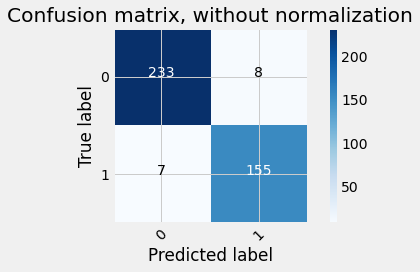

In [79]:
labels_pred = model.predict(data_test)
cnf_matrix = confusion_matrix(labels_test, labels_pred, labels=[0,1])
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')

In [80]:
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       241
           1       0.95      0.96      0.95       162

    accuracy                           0.96       403
   macro avg       0.96      0.96      0.96       403
weighted avg       0.96      0.96      0.96       403



### Outcome : The oversampling does not make better results. 

# Lets try with undersampling : 

In [81]:
print(Counter(labels_train))

Counter({0: 723, 1: 486})


In [82]:
under = RandomUnderSampler(sampling_strategy = {0: 400, 1: 485})
X, Y = under.fit_resample(data_train, labels_train)

In [83]:
model.fit(X, Y)

RandomForestClassifier(max_depth=10, n_estimators=15, n_jobs=-1,
                       random_state=42)

In [84]:
get_scores(model)

Train:  0.9818031430934657
Validation:  0.9553349875930521


Confusion matrix, without normalization
[[226  15]
 [  3 159]]


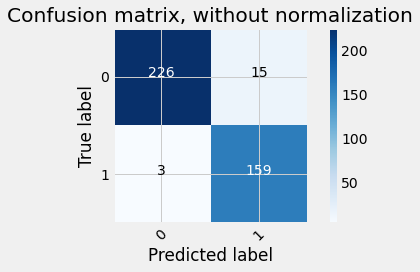

In [85]:
labels_pred = model.predict(data_test)
cnf_matrix = confusion_matrix(labels_test, labels_pred, labels=[0,1])
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')

In [86]:
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       241
           1       0.91      0.98      0.95       162

    accuracy                           0.96       403
   macro avg       0.95      0.96      0.95       403
weighted avg       0.96      0.96      0.96       403



In [87]:
print(Counter(labels_train))

Counter({0: 723, 1: 486})


In [88]:
over = RandomOverSampler(sampling_strategy = {0: 724, 1: 600})
X, Y = over.fit_resample(data_train, labels_train)
under = RandomUnderSampler(sampling_strategy = {0: 400, 1: 600})
X, Y = under.fit_resample(X, Y)

/home/indzhov/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:326: UserWarning:

After over-sampling, the number of samples (724) in class 0 will be larger than the number of samples in the majority class (class #0 -> 723)



In [89]:
model.fit(X, Y)

RandomForestClassifier(max_depth=10, n_estimators=15, n_jobs=-1,
                       random_state=42)

In [90]:
get_scores(model)

Train:  0.9751861042183623
Validation:  0.9354838709677419


### The result is even worse. Lets so lets proceed with the original one . 
But first lets add the validation columns we splited in the begining and see if there is a trend in the acceptance of an offer. Here we are going to approve or reject our first Hypothesis. 

In [91]:
data["persona"] = kmeans.labels_

In [92]:
replaced = {0: "Bad", 1 : "Good"}

In [93]:
data.persona.replace(replaced, inplace=True)

In [94]:
data = data.join([validation])

Now as we have added the validation columns, which we have separate in the begining, we can see if there is a significant difference in the way the clients from different group accept offers. 

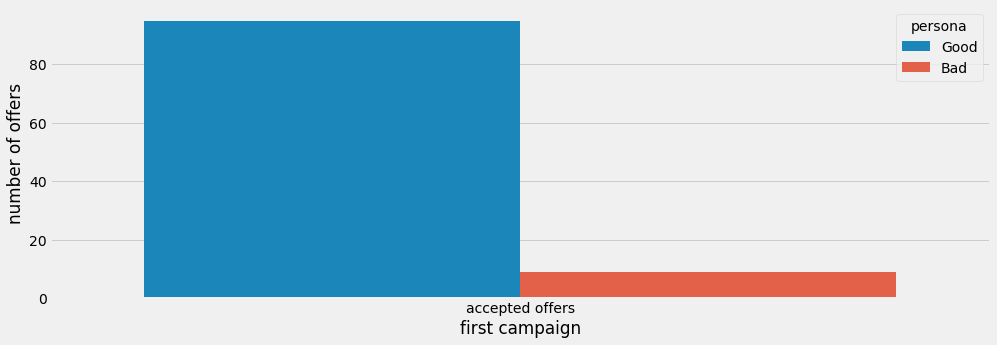

In [95]:
plt.subplots(figsize = (15,5))
sns.countplot(x=data['first'],order=[1],hue=data['persona'])
plt.savefig('graphs/outcome1.png')
plt.ylabel("number of offers")
plt.xlabel("first campaign")
plt.xticks(range(1), ["accepted offers"])
plt.show()

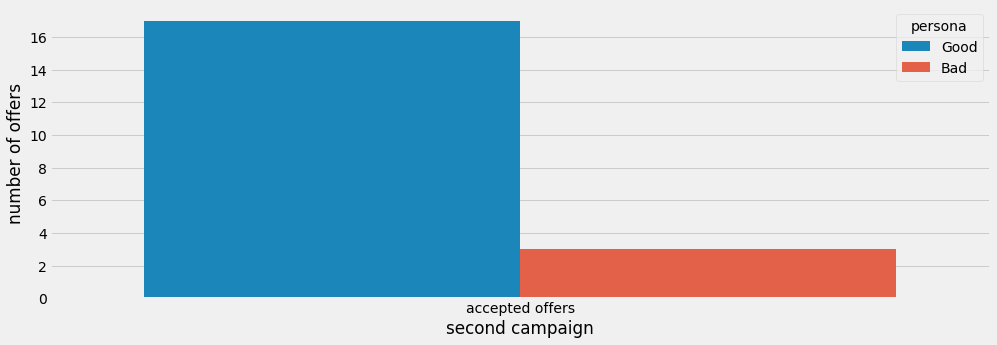

In [96]:
plt.subplots(figsize = (15,5))
sns.countplot(x=data['second'],order=[1],hue=data['persona'])
plt.savefig('graphs/outcome2.png')
plt.ylabel("number of offers")
plt.xlabel("second campaign")
plt.xticks(range(1), ["accepted offers"])
plt.show()

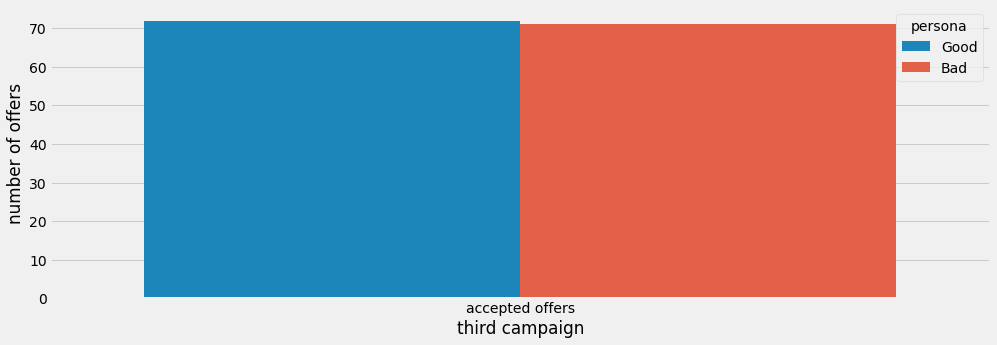

In [97]:
plt.subplots(figsize = (15,5))
sns.countplot(x=data['third'],order=[1],hue=data['persona'])
plt.savefig('graphs/outcome3.png')
plt.ylabel("number of offers")
plt.xlabel("third campaign")
plt.xticks(range(1), ["accepted offers"])
plt.show()

We can see how to the third campign, in the first two most people from the class 1 have taken the offer in the past. 
### Here we can approve the H0 and say : Yes, there is a pattern of the different groups, in respect to the acceptance of the offer in the first campaings

### Now we can continue to the saving of the model : 

In [98]:
pickle.dump(model, open('persona.pkl', 'wb'))

# Conclusion : 

### 1.What we have done :
* Cleaned the dataset 
* Removed the ourliers 
* Calculate the overall spending for every client
* Found the optimal number of clusters
* Found the good and bad clinets for our business
* Done feature engeneering
* Use the information for creating a model to evaluate a potential client

### 2. Hypothesis : 
* H0 - Yes, there is a difference between the way the clients with different persona accept an offer
* H1 - The wine lovers are older clients
* H2 - Our site visitors are very loyal
* H3 - Clients with higher income buys more
* H4 - The clients, who visit our website most are not the same, who buys from it

### 3. Outcomes : 
* We need to promote more Wines and Meat
* To target people between 40 and 60 ages
* To promote most on our catalog and website
* To target more people with childs 
* To target those who have graduated, have PhD or Masters degree.
* Before the project, we even did not have an idea of which clients are bringing most revenue to us. 

Sources : 
- The Evaluation of silhouette score - https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
- The function for evaluating the time of different Supervised algorithms - Thanks to Shadab Hussain

# self-assessment :

In [99]:
self_assessment = "" # This is an empty variable, which we are going to fill with our Introduction.
with open("project-info.txt", "r", encoding = "utf-8") as file: #The load file is loaded 
    self_assessment = file.read() # The variable reads the text. 
print(self_assessment) #Lets see it: 

﻿# Machine Learning
## Final Exam Assessment Guidelines

## Project name: 
## Project author:

### Terms and conditions:
* Use Jupyter notebook for text and maths. You can use any programming language you would like.
* Write your research and code in English. Bulgarian is also acceptable but try to use English.
* If you have sensitive, copyrighted, or copy-protected assets, including but not limited to, images, multimedia, code, documents, and datasets,
  you can sign an NDA (non-disclosure agreement) with the SoftUni team. Contact the lecturer if you need assistance with the process.
* Any code which does not comply with the Bulgarian law (as of the exam date), will be given zero points.
* Any malicious code, or code intended to do harm to the user's computer, information, or privacy, will be given zero points.

By submitting your project for the exam, you agree with these terms and conditions.

### Self-assessment:
The numbers in brackets define possible points for the corresponding 

### in other words, I would give myself a 5/6